In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import pathlib
from sklearn.preprocessing import LabelBinarizer

In [2]:
# Loading our CSV data into variables we can use
main_data = pd.read_csv('extended_neg.csv')
file_paths = main_data['Image']
lb = LabelBinarizer()


labels = main_data['Sentiment']
bin_labels = lb.fit_transform(labels)
binary_values = lb.transform(labels)
print(binary_values)
binary_values
labels

[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


0        Positive
1        Positive
2        Negative
3        Positive
4        Negative
           ...   
16386    Negative
16387    Negative
16388    Negative
16389    Negative
16390    Negative
Name: Sentiment, Length: 16391, dtype: object

In [3]:
# Our classes, 0 = Negative, 1 = Positive
lb.classes_

array(['Negative', 'Positive'], dtype='<U8')

In [4]:
# 80% train, 10% validation, 10% test
train_file_paths, temp_file_paths, train_labels, temp_labels = train_test_split(
    file_paths, bin_labels, test_size=0.2, random_state=84)

val_file_paths, test_file_paths, val_labels, test_labels = train_test_split(
    temp_file_paths, temp_labels, test_size=0.5, random_state=69)

In [5]:
# NO DATA AUGMENTATION

def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)  # Use decode_png for PNG images
    img = tf.image.resize(img, [256, 256])  # Resize images to a fixed size
    img = img / 255.0  # Normalize pixel values
    return img, label

In [6]:
# Data sets using tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

In [7]:
# Mapping datasets
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Setting our batch size
batch_size = 16  # CHANGE THIS AS NEEDED

# Shuffling datasets
train_dataset = train_dataset.shuffle(buffer_size=len(train_file_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
def create_cnn(input_shape, num_classes):
    model = Sequential()

    # First conv layer
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third conv layer
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fourth conv layer
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully Connected Layer
    #model.add(Dense(256, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

In [10]:
input_shape = (256, 256, 3) # Width, Height, Channels (RGB)

num_classes = 1 # Positive, Neutral Negative

model = create_cnn(input_shape, num_classes) 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [12]:
with tf.device('/GPU:0'):
    model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
139/820 [====>.........................] - ETA: 18s - loss: 0.6592 - accuracy: 0.5917

KeyboardInterrupt: 

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test accuracy: ", test_accuracy)

205/205 [==============================] - 1s 7ms/step - loss: 0.5805 - accuracy: 0.7091
Test accuracy:  0.7091463208198547


In [17]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

In [15]:
model.save('main.h5')

In [18]:
# Used for model testing, can be ran before or after training if model exists
from tensorflow.keras.models import load_model
model = load_model('main.h5')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np


all_predictions = []
all_true_labels = []


for images, labels in test_dataset:
    predictions = model.predict(images)

    binary_predictions = (predictions > 0.5).astype(int)
    all_predictions.extend(np.squeeze(binary_predictions))
    all_true_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(all_true_labels, all_predictions)

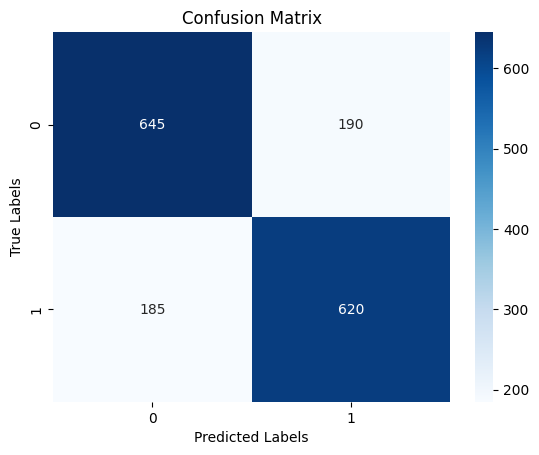

In [21]:
# Create a confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 77.13%
